# **Time Series Analysis and Prediction**

In [ ]:
!pip install statsmodels
!pip install pmdarima --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.9 MB/s eta 0:00:00


In [ ]:
#imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

## **Application 1: Deman Forecasting (Air Passenger)**

**Data Preprocessing**

In [ ]:
#upload airPassengers.cvs

airpass=pd.read_csv("/content/AirPassengers.csv")
airpass.shape

(144, 2)

In [ ]:
plt.style.use('dark_background')

In [ ]:
#change column name
airpass.rename(columns = {'Month':'Date','#Passengers':'Passengers'}, inplace = True)
#convert date datatype to date
airpass['Date'] = pd.to_datetime(airpass['Date'])

#changing index
airpass.set_index('Date', inplace=True)

airpass.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### **Time Series EDA**

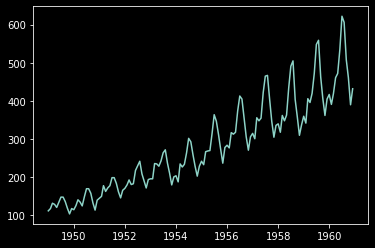

In [ ]:
#plotting passangers over date
plt.plot(airpass['Passengers'])

**Check if Data is stationary?**

In [ ]:
#Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(airpass)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is not stationary, we may need SARIMA and not just ARIMA

pvalue =  0.991880243437641  if above 0.05, data is not stationary


**Extract and plot trend, seasonal and residuals.**

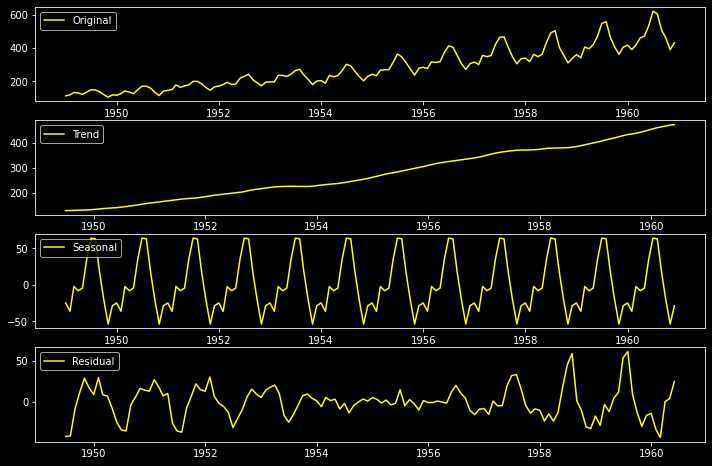

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


decomposed = seasonal_decompose(airpass['Passengers'],  model ='additive') #try model=Multiplicative

trend = decomposed.trend #there is positive growth trend
seasonal = decomposed.seasonal #the graph shows the cycle is yearly
residual = decomposed.resid #this is error so we should not see a pattern

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(airpass['Passengers'], label='Original', color='yellow')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='yellow')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='yellow')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='yellow')
plt.legend(loc='upper left')
plt.show()

**Finding Monthly trends**

In [ ]:
#create a new dataframe years with month as rows
years=pd.DataFrame(index=range(1,13)) #get 12 month as rows
airpass=airpass.reset_index()

#group by columns by year
#create column for each year and destribute the values over months
for name, year_df in airpass.groupby(airpass["Date"].apply(lambda x: x.year)):
  years[name]=year_df["Passengers"].values

years

,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
1,112,115,145,171,196,204,242,284,315,340,360,417
2,118,126,150,180,196,188,233,277,301,318,342,391
3,132,141,178,193,236,235,267,317,356,362,406,419
4,129,135,163,181,235,227,269,313,348,348,396,461
5,121,125,172,183,229,234,270,318,355,363,420,472
6,135,149,178,218,243,264,315,374,422,435,472,535
7,148,170,199,230,264,302,364,413,465,491,548,622
8,148,170,199,242,272,293,347,405,467,505,559,606
9,136,158,184,209,237,259,312,355,404,404,463,508
10,119,133,162,191,211,229,274,306,347,359,407,461


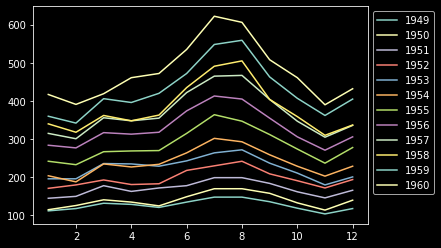

In [ ]:
years.plot().legend(bbox_to_anchor=(1, 1))

**Auto Correlation**<br>
in time series, variable is correlated to itself over a lag. a lag is a period of time (interval) between 2 points of time we like to find  the correlation value for.

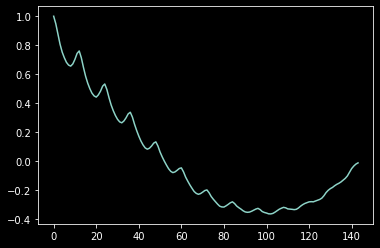

In [ ]:
from statsmodels.tsa.stattools import acf

acf_144 = acf(airpass["Passengers"], nlags=144)
plt.plot(acf_144)

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


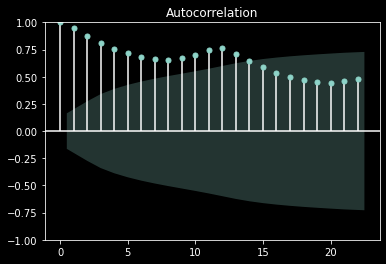

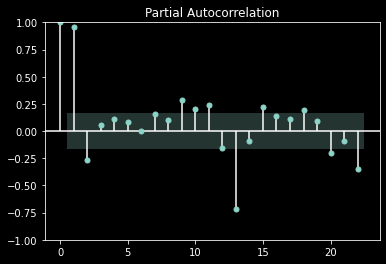

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(airpass["Passengers"])
plot_pacf(airpass["Passengers"]);

In [ ]:
#get autocorrelation based on specific lag
airpass.Passengers.autocorr(12)

0.990527369208544

**Manually creating auto correlation function using pandas shift function**

In [ ]:

ac_df=airpass.copy()
#lag here is 3 month ago  which means value at 4th row of original column, becomes value at 1st row of new column
ac_df["shift-3"]=ac_df["Passengers"].shift(-3)

In [ ]:
ac_df["shift12"]=ac_df["Passengers"].shift(12) #check how correlated is data on reayly basis

In [ ]:
ac_df.corr().Passengers

Passengers    1.000000
shift-3       0.837395
shift12       0.990527
Name: Passengers, dtype: float64

### **Lagged-Regression**


In [ ]:
from statsmodels.tsa.ar_model import AutoReg
model1=AutoReg(airpass,3)
res=model1.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:             Passengers   No. Observations:                  144
Model:                     AutoReg(3)   Log Likelihood                -684.430
Method:               Conditional MLE   S.D. of innovations             31.037
Date:                Sun, 05 Mar 2023   AIC                           1378.860
Time:                        12:27:07   BIC                           1393.603
Sample:                    04-01-1949   HQIC                          1384.851
                         - 12-01-1960                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.6410      6.872      1.985      0.047       0.172      27.110
Passengers.L1     1.3482      0.084     16.025      0.000       1.183       1.513
Passengers.L2    -0.5918      0.136     

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


**Manually building regression model**

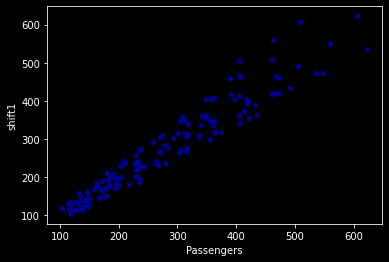

In [ ]:
ar=airpass.copy()
ar["shift1"]=ar["Passengers"].shift(1)
ax1 = ar.plot.scatter(x='Passengers',
                      y='shift1',
                      c='DarkBlue')

In [ ]:
ar["shift2"]=ar["Passengers"].shift(2)
ar["shift3"]=ar["Passengers"].shift(3)

In [ ]:
ar.drop("Passengers", axis=1, inplace=True)

In [ ]:
ar

In [ ]:
#convert dataframe into numpy
x=ar.fillna(0).values

In [ ]:
y=airpass.fillna(0).values

In [ ]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(x,y)
print(lr.coef_,lr.intercept_)

[[ 1.29840954 -0.51832797  0.16594546]] [17.54351302]


### **Forecasting using ARIMA/SARIMA/SARIMAX**<br>
ARIMA:Auto-Regressive Integrated Moving Average<br>
SARIMA: Seasonal ARIMA<br>
SARIMAX: SARIMA with Exogenous variables

In [ ]:
#changing index
airpass.set_index('Date', inplace=True)

In [ ]:
from pmdarima.arima import auto_arima
#Auto arima suggests best model and parameters based on
#AIC metric (relative quality of statistical models)
#Autoarima gives us best model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components
arima_model = auto_arima(airpass['Passengers'], start_p = 1, d=1, start_q = 1,
                          max_p = 5, max_q = 5, max_d=5, m = 12,
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, trace = True,
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True, n_fits=50)

print(arima_model.summary() ) #check MODEL to see best model for the data

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.40 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1020.582, Time=0.89 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.62 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.52 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=7.07 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.45 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.57 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.72 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.48 sec
 ARIMA(0,1,1)(1,1,0)[12]     

In [ ]:
#Split data into train and test (take the first 66% as test and the rest as training)
size = int(len(airpass) * 0.66)
X_train, X_test = airpass[0:size], airpass[size:len(airpass)]

In [ ]:
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(X_train['Passengers'],
                order = (0, 1, 1),
                seasonal_order =(2, 1, 1, 12))

result = model.fit()
result.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Passengers   No. Observations:                   95
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -300.269
Date:                            Sun, 05 Mar 2023   AIC                            610.537
Time:                                    11:55:36   BIC                            622.571
Sample:                                01-01-1949   HQIC                           615.368
                                     - 11-01-1956                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3201      0.103     -3.103      0.002      -0.522      -0.118
ar.S.L12       0.6847      0.609      1.124      0.261      -0.509       1.878
ar.S.L24       0.3142      0.125      2.520      0.012       0.070       0.559
ma.S.L12      -0.9812      5.431     -0.181      0.857     -11.626       9.664
sigma2        78.6460    379.218      0.207      0.836    -664.607     821.899
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.56
Prob(Q):                              0.95   Prob(JB):                         0.28
Heteroskedasticity (H):               1.69   Skew:                             0.42
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#Train prediction
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index)

In [ ]:
#TEST Prediction
start_index = len(X_train)
end_index = len(airpass)-1
prediction = result.predict(start_index, end_index).rename('Predicted passengers')

<AxesSubplot:xlabel='Date'>

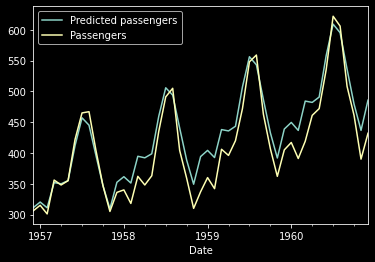

In [ ]:
# plot predictions and actual values
prediction.plot(legend = True)  #prediction
X_test['Passengers'].plot(legend = True) #actual data

In [ ]:
#forecasting
forecast = result.predict(start = len(airpass),
                          end = (len(airpass)-1) + 3 * 12,  # forecast for the next 3 years
                          typ = 'levels').rename('Forecast')

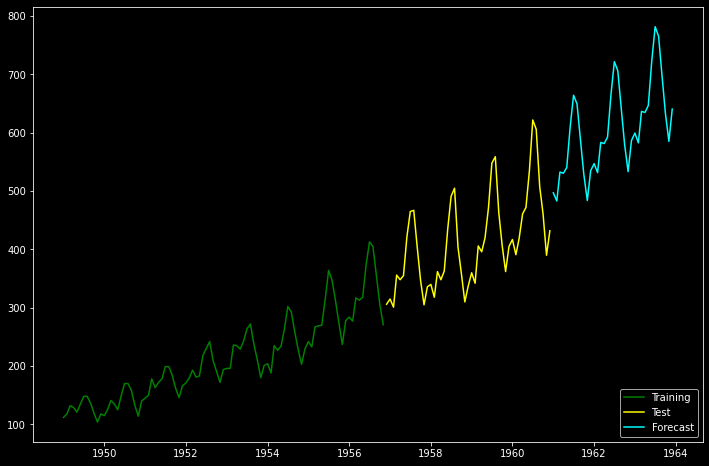

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(X_train, label='Training', color='green')
plt.plot(X_test, label='Test', color='yellow')
plt.plot(forecast, label='Forecast', color='cyan')
plt.legend(loc='lower right')
plt.show();

### **Forecasting using LSTM**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
#drop the date column
airpass_=airpass.copy()
airpass_.reset_index(inplace=True)
airpass_.drop("Date", axis=1, inplace=True)

In [ ]:
#scaling the data between minimum and maximum passanger number
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(airpass_)

In [ ]:
#Split data into train and test (take the first 66% as test and the rest as training)
size = int(len(dataset) * 0.66)
train, test = dataset[0:size], dataset[size:len(airpass)]

In [ ]:
#greate a sequence of n+1 (n=feature=number of months to look back, n+1 is the lable)
#seq_size=n
def to_sequences(dataset, seq_size=5):
    x = []
    y = []
    last_index_for_sequence=len(dataset)-seq_size-1
    for i in range(last_index_for_sequence):
        window = dataset[i:(i+seq_size), 0]
        x.append(window) #creating feature set array
        y.append(dataset[i+seq_size, 0]) #creating lable array

    return np.array(x),np.array(y)

In [ ]:
seq_size = 12
trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)
print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))

Shape of training set: (82, 12)
Shape of test set: (36, 12)


In [ ]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(None, seq_size)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 50)          12600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 34,465
Trainable params: 34,465
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/100
3/3 - 7s - loss: 0.0665 - val_loss: 0.3623 - 7s/epoch - 2s/step
Epoch 2/100
3/3 - 0s - loss: 0.0541 - val_loss: 0.3225 - 86ms/epoch - 29ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0428 - val_loss: 0.2834 - 92ms/epoch - 31ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0331 - val_loss: 0.2446 - 108ms/epoch - 36ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0256 - val_loss: 0.2059 - 67ms/epoch - 22ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0197 - val_loss: 0.1691 - 75ms/epoch - 25ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0157 - val_loss: 0.1354 - 89ms/epoch - 30ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0131 - val_loss: 0.1077 - 94ms/epoch - 31ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0132 - val_loss: 0.0853 - 100ms/epoch - 33ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0137 - val_loss: 0.0717 - 86ms/epoch - 29ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0140 - val_loss: 0.0653 - 73ms/epoch - 24ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0137 - val_loss: 0.0646 - 72ms/epoch - 24ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0128 - 

In [ ]:
#since we scaled the data, now we need to convert the scaled data back to actual data
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 13.57 RMSE
Test Score: 74.77 RMSE


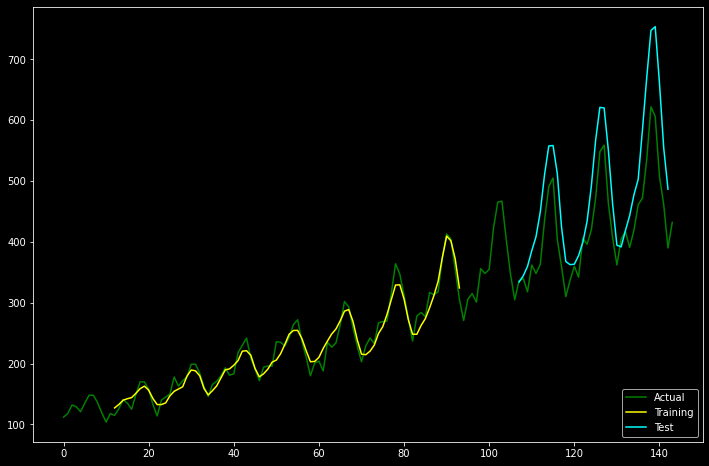

In [ ]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset.
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(12,8))
plt.plot(scaler.inverse_transform(dataset),  label='Actual', color='green')
plt.plot(trainPredictPlot, label='Training', color='yellow')
plt.plot(testPredictPlot, label='Test', color='cyan')
plt.legend(loc='lower right')
plt.show()



### **Similar applications**
* [Taxi Deman Forecasting - Russian :D](https://github.com/anafisa/NYC-Taxi-Demand-Prediction/blob/main/03_complex_seasonal_forecasting.ipynb)
* [Web Traffic Analysis](https://github.com/Subikshaa/Time-Series-Forecasting-on-Web-Traffic-Dataset/blob/master/forecast_CNN.ipynb)

## **Application2: Stock Price Analysis and Forecasting**

**Exercise1:**

* go to yahoo finance, and download the stock exchange data of any of the top UAE companies from the first available day till today (Examle [Emaar Dataset](https://finance.yahoo.com/quote/EMAAR.AE/history?p=EMAAR.AE))
* Apply above EDA and more if you are interested on the dataset
* Using [LSTM Autoencoder](#https://github.com/bnsreenu/python_for_microscopists/blob/master/180_LSTM_encoder_decoder_anomaly_GE.py) find all anomalies, and google the dates with anomalies to explain the cause of the anomaly
* using ARIMA sample above and [ConvLSTM2D](https://github.com/bnsreenu/python_for_microscopists/blob/master/166a-Intro_to_time_series_Forecasting_using_LSTM.py), predict the stock price for each day in the next 90 days using all variables. For multi variant prediction [check this](https://github.com/bnsreenu/python_for_microscopists/blob/master/181_multivariate_timeseries_LSTM_GE.py)
* Compare the models using RMSE score for both training and test dataset

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Dropout

# Load the data
data = pd.read_csv("/content/MASQ.AE.csv")

# Convert the date column to a datetime object and set it as the index
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)
# Drop rows with NaN values
data.dropna(inplace=True)

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[["Open","High", "Low", "Close", "Adj Close", "Volume"]])

def create_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size - 1):
        X.append(data[i:(i + window_size), :])
        y.append(data[(i + window_size), :])
    return np.array(X), np.array(y)

window_size = 10

X, y = create_windows(scaled_data, window_size)

model = Sequential([
    LSTM(256, activation="relu", input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(128, activation="relu", return_sequences=False),
    Dropout(0.2),
    RepeatVector(1),
    LSTM(128, activation="relu", return_sequences=True),
    Dropout(0.2),
    LSTM(256, activation="relu", return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(X.shape[2]))
])

model.compile(optimizer="adam", loss="mse")
model.fit(X, y, epochs=10, batch_size=25, verbose=2)

reconstructed_data = model.predict(X)[:, 0, :]  # Add this index to select the first timestep only
mse = np.mean(np.power(y - reconstructed_data, 2), axis=1)

threshold = np.quantile(mse, 0.99)  # 99% quantile as the threshold for anomalies

anomalies = data.iloc[window_size + 1:][mse > threshold]

print("Anomaly Dates:")
print(anomalies.index)

Epoch 1/10
124/124 - 16s - loss: 0.0476 - 16s/epoch - 127ms/step
Epoch 2/10
124/124 - 9s - loss: 0.0311 - 9s/epoch - 74ms/step
Epoch 3/10
124/124 - 9s - loss: 0.0310 - 9s/epoch - 74ms/step
Epoch 4/10
124/124 - 8s - loss: 0.0305 - 8s/epoch - 63ms/step
Epoch 5/10
124/124 - 9s - loss: 0.0305 - 9s/epoch - 73ms/step
Epoch 6/10
124/124 - 9s - loss: 0.0306 - 9s/epoch - 74ms/step
Epoch 7/10
124/124 - 8s - loss: 0.0303 - 8s/epoch - 64ms/step
Epoch 8/10
124/124 - 9s - loss: 0.0301 - 9s/epoch - 73ms/step
Epoch 9/10
124/124 - 9s - loss: 0.0301 - 9s/epoch - 74ms/step
Epoch 10/10
124/124 - 8s - loss: 0.0301 - 8s/epoch - 64ms/step
97/97 [==============================] - 3s 24ms/step
Anomaly Dates:
DatetimeIndex(['2014-05-06', '2014-05-07', '2014-08-05', '2014-08-06',
               '2014-08-28', '2014-08-31', '2014-09-01', '2014-09-02',
               '2014-10-16', '2014-10-19', '2015-02-02', '2015-02-08',
               '2015-02-09', '2015-02-10', '2015-02-11', '2015-02-12',
               '2015-02

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.0 MB/s eta 0:00:00


Optimal ARIMA Model Parameters:
{'maxiter': 50, 'method': 'lbfgs', 'order': (1, 1, 1), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (0, 0, 0, 0), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}

Forecasted stock prices for the next 90 days:
3099    115.284754
3100    115.530282
3101    115.741987
3102    115.924528
3103    116.081924
           ...    
3184    117.067089
3185    117.067090
3186    117.067090
3187    117.067091
3188    117.067092
Length: 90, dtype: float64


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


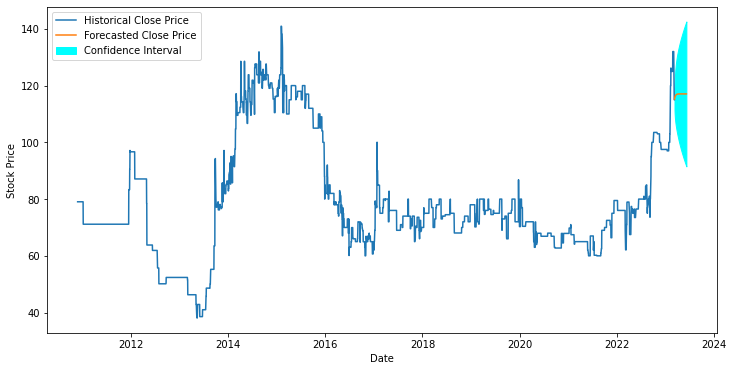

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from sklearn.metrics import mean_squared_error

# Install pmdarima if you don't have it already
# !pip install pmdarima

# Load the data
data = pd.read_csv("/content/MASQ.AE.csv")

# Convert the date column to a datetime object and set it as the index
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)
# Drop rows with NaN values
data.dropna(inplace=True)

# Use the 'Close' price for prediction
close_price = data['Close']

# Split the data into train and test sets
train_size = int(len(close_price) * 0.8)
train_data, test_data = close_price[:train_size], close_price[train_size:]

# Use auto_arima to find the optimal ARIMA parameters
auto_model = pm.auto_arima(close_price, seasonal=False, suppress_warnings=True)

# Display the optimal ARIMA model's parameters
print("Optimal ARIMA Model Parameters:")
print(auto_model.get_params())

# Forecast the next 90 days
forecast_steps = 90
forecast, conf_int = auto_model.predict(n_periods=forecast_steps, return_conf_int=True)

# Print the forecasted stock prices
print("\nForecasted stock prices for the next 90 days:")
print(forecast)

# Plot the forecasted stock prices
# Plot the forecasted stock prices
# Plot the forecasted stock prices
plt.figure(figsize=(12, 6))
plt.plot(close_price.index, close_price, label="Historical Close Price")

# Generate forecast dates starting from the day after the last date in the dataset
forecast_dates = pd.date_range(close_price.index[-1] + pd.Timedelta(days=1), periods=forecast_steps)
plt.plot(forecast_dates, forecast, label="Forecasted Close Price")
plt.fill_between(forecast_dates, conf_int[:, 0], conf_int[:, 1], color='cyan', label="Confidence Interval")

plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load the data
data = pd.read_csv("/content/MASQ.AE.csv")

# Convert the date column to a datetime object and set it as the index
data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)
# Drop rows with NaN values
data.dropna(inplace=True)

# Use the 'Close', 'High', and 'Low' prices for prediction
prices = data[['Close', 'High', 'Low']]

# Scale the data
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, :])
    return np.array(X), np.array(Y)

look_back = 10
X, Y = create_dataset(scaled_prices, look_back)

# Split the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[0:train_size], X[train_size:]
Y_train, Y_test = Y[0:train_size], Y[train_size:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(X_train, Y_train, epochs=20, batch_size=1, validation_data=(X_test, Y_test), callbacks=[early_stop], verbose=1, shuffle=False)

# Forecast the next 90 days
forecast = []
current_batch = X[-1].reshape((1, look_back, 3))

for i in range(90):
    current_pred = model.predict(current_batch)[0]
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

# Inverse transform the forecasted prices
forecast = scaler.inverse_transform(forecast)

# Print the forecasted stock prices
print("\nForecasted stock prices (Close, High, Low) for the next 90 days:")
print(forecast)


Epoch 1/20
2470/2470 [==============================] - 23s 7ms/step - loss: 0.0022 - val_loss: 0.0129
Epoch 2/20
2470/2470 [==============================] - 15s 6ms/step - loss: 0.0013 - val_loss: 0.0128
Epoch 3/20
2470/2470 [==============================] - 15s 6ms/step - loss: 0.0010 - val_loss: 0.0095
Epoch 4/20
2470/2470 [==============================] - 16s 6ms/step - loss: 8.3348e-04 - val_loss: 0.0075
Epoch 5/20
2470/2470 [==============================] - 15s 6ms/step - loss: 7.3411e-04 - val_loss: 0.0063
Epoch 6/20
2470/2470 [==============================] - 15s 6ms/step - loss: 6.5423e-04 - val_loss: 0.0053
Epoch 7/20
2470/2470 [==============================] - 15s 6ms/step - loss: 6.0143e-04 - val_loss: 0.0047
Epoch 8/20
2470/2470 [==============================] - 15s 6ms/step - loss: 5.5873e-04 - val_loss: 0.0043
Epoch 9/20
2470/2470 [==============================] - 15s 6ms/step - loss: 5.6103e-04 - val_loss: 0.0041
Epoch 10/20
2470/2470 [==========================

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Model 1: ARIMA
train_pred_arima_full, _ = auto_model.predict_in_sample(return_conf_int=True)
train_pred_arima = train_pred_arima_full[:train_size]  # Slice the predictions to match the training dataset size
test_pred_arima, _ = auto_model.predict(n_periods=len(close_price) - train_size, return_conf_int=True)

train_rmse_arima = sqrt(mean_squared_error(close_price[:train_size], train_pred_arima))
test_rmse_arima = sqrt(mean_squared_error(close_price[train_size:], test_pred_arima))

print("ARIMA Model:")
print("Training RMSE:", train_rmse_arima)
print("Test RMSE:", test_rmse_arima)

# Model 2: LSTM
train_pred_lstm = model.predict(X_train)
test_pred_lstm = model.predict(X_test)

# Inverse transform the predictions
train_pred_lstm_inv = scaler.inverse_transform(train_pred_lstm)[:, 0]  # Get 'Close' prices only
test_pred_lstm_inv = scaler.inverse_transform(test_pred_lstm)[:, 0]  # Get 'Close' prices only

train_rmse_lstm = sqrt(mean_squared_error(prices.iloc[look_back:train_size + look_back, 0], train_pred_lstm_inv))
test_rmse_lstm = sqrt(mean_squared_error(prices.iloc[train_size + look_back +1:-1, 0], test_pred_lstm_inv[:-1]))

print("\nLSTM Model:")
print("Training RMSE:", train_rmse_lstm)
print("Test RMSE:", test_rmse_lstm)


ARIMA Model:
Training RMSE: 2.5745107176352793
Test RMSE: 44.13011348590641
 9/78 [==>...........................] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


20/20 [==============================] - 0s 5ms/step

LSTM Model:
Training RMSE: 9.189354269885438
Test RMSE: 6.4496826809942505
